# SC1015 DSAI Mini Project
## Part 3: Dimension Reduction
---
As we have seen in `Part 1: Data Preparation and Cleaning`, our data (the `conv_vars_df`) has a high dimension: there are a total of `94` columns (a result of encoding our 6 variables). Using such a high dimension of data to perform clustering would probably not result in nicely formulated clusters and in turn that would mean we would be unable to answer the question we posed. Besides, working with high dimensional data is generally difficult because of the time (and of course space) complexity increases as well as the inability to visualize.  Hence, in this section, we perform dimensionality reduction in hopes to reduce the number of columns to a more workable amount.

We use the **Multiple Correspondence Analysis (MCA)** algorithm to achieve this. The choice of the algorithm was based on the categorical nature of our data. The general convention when performing dimensionality reduction seems to be Principal Component Analysis (PCA) but it unfortunately does not work well with categorical data. MCA is considered to be the categorical equivalent of PCA which is why we have chosen this algorithm. 

After performing MCA, our data does get transformed to numeric however. This is a useful by-product of reducing dimensions since it allows us to use clustering algorithms that work with numeric data.

**Question:** Does Being Unconventional Determine Success?

**Dataset:** [Stack Overflow Developer Survey 2020 on Kaggle](https://www.kaggle.com/aitzaz/stack-overflow-developer-survey-2020)

## Table of Contents:
1. [Plotting Explained Inertia vs. `n_components`](#1\.-Plotting-Explained-Inertia-vs\.-n_components)
2. [Determining Optimal `n_components`](#2\.-Determining-Optimal-n_components)
3. [Creating a DataFrame with Optimal `n_components`](#3\.-Creating-a-DataFrame-with-Optimal-n_components)
4. [Converting DataFrame to Pickle File](#4\.-Converting-DataFrame-to-Pickle-File)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

from prince import MCA

# set seaborn to default
sb.set()

In [2]:
conv_vars_df = pd.read_pickle('conv_vars_data.pickle')
conv_vars_df

DatabaseWorkedWith                                                    \
               Cassandra Couchbase DynamoDB Elasticsearch Firebase IBM DB2   
0                      0         0        0             0        0       0   
1                      0         0        0             0        0       0   
2                      0         0        0             0        1       0   
3                      0         0        0             0        1       0   
4                      0         0        0             0        0       0   
...                  ...       ...      ...           ...      ...     ...   
19357                  0         0        0             0        0       0   
19358                  1         0        1             1        0       0   
19359                  0         0        0             0        0       0   
19360                  0         0        0             0        1       0   
19361                  0         0        0             0        0       0   

                                                  ... WebframeWorkedWith  \
      MariaDB Microsoft SQL Server MongoDB MySQL  ...            Express   
0           1                    0       0     1  ...                  0   
1           0                    1       0     0  ...                  0   
2           0                    0       1     0  ...                  0   
3           0                    1       0     0  ...                  0   
4           1                    1       0     0  ...                  0   
...       ...                  ...     ...   ...  ...                ...   
19357       1                    1       1     0  ...                  1   
19358       1                    0       1     1  ...                  0   
19359       0                    1       0     0  ...                  0   
19360       0                    0       1     1  ...                  0   
19361       0                    0       0     1  ...                  0   

                                                                                
      Flask Gatsby Laravel React.js Ruby on Rails Spring Symfony Vue.js jQuery  
0         1      0       0        0             0      0       0      0      0  
1         1      0       0        0             0      0       0      0      1  
2         0      0       0        1             0      0       0      0      0  
3         0      0       0        0             0      0       0      1      0  
4         0      0       0        0             0      0       0      0      0  
...     ...    ...     ...      ...           ...    ...     ...    ...    ...  
19357     1      1       0        1             0      0       0      1      0  
19358     0      0       0        1             0      0       0      0      0  
19359     0      0       0        0             0      0       0      0      0  
19360     0      0       0        1             1      0       0      0      1  
19361     0      0       0        0             0      0       0      0      1  

[19362 rows x 94 columns]

### 1. Plotting Explained Inertia vs. `n_components`

MCA outputs different Principal Components (PCs) which are new columns that represent the original dataset. The first PC represents most of the original data, the second PC the second most of the data and so on until the last one which represents the least of the original data.

Using MCA we can, for instance, input a 25 column data such as our `LanguageWorkedWith` variable and get an output with just 2 PCs (columns). These 2 PCs will attempt to represent data from all our 25 original columns.

The parameter `n_component` determines how many PCs we want the algorithm to output. 

The measure of how much representation has been done by each PC is given by Explained Inertia which essentially shows how much of the spread of the original data is preserved after the transformation of the data into PCs. 

In this section, we plot Explained Inertia vs `n_components` for each of our 6 conventionality variables individually after performing MCA on them to get a general idea of how much inertia the PCs are explaining. We do this by setting the `n_components` to the number of columns in our original dataset. 

In [3]:
# conv_vars_df has multi level (2) column labels
# extracting labels for each level 

all_cols = []
for col_tuple in conv_vars_df:
    all_cols.append(col_tuple[0])
unique_cols = list(set(all_cols))

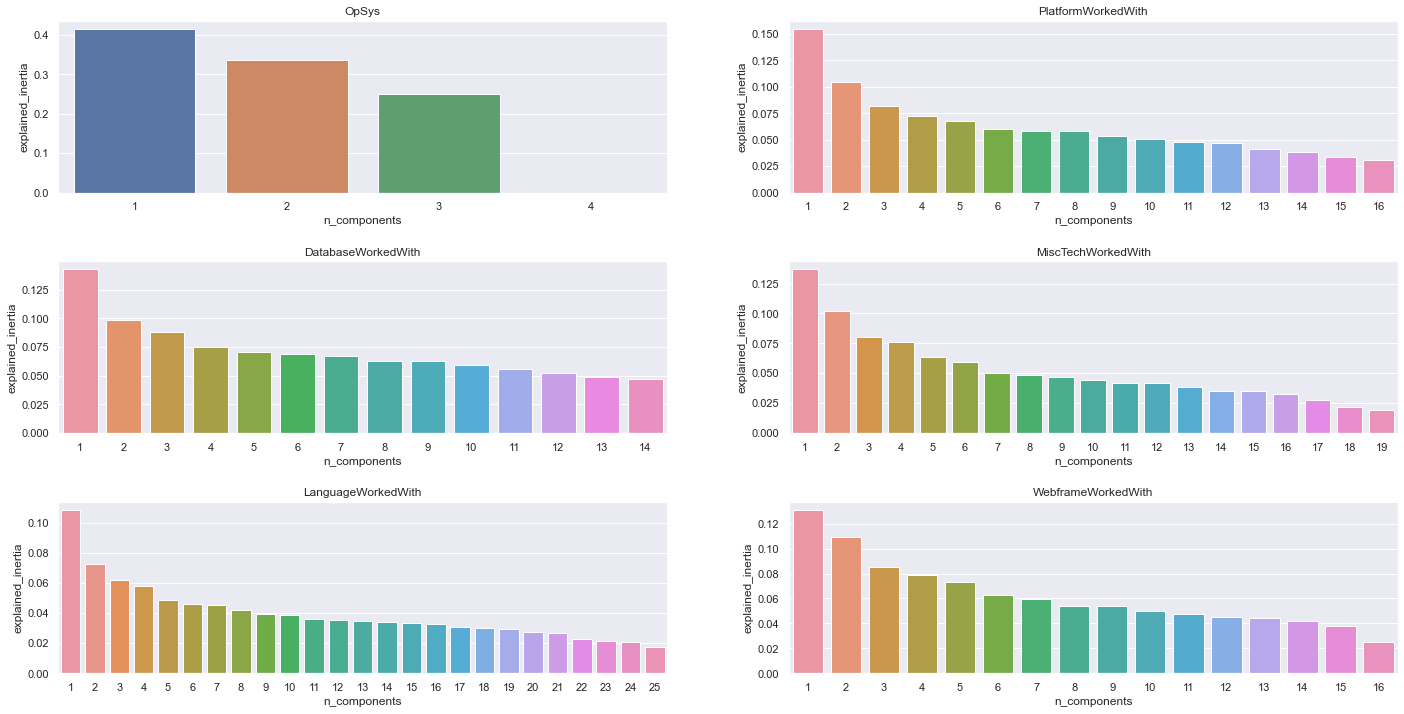

In [4]:
fig = plt.figure(figsize=(24, 12))
gs = fig.add_gridspec(3, 2, hspace=0.4)
axes = gs.subplots()

for ax in axes.flat:
    ax.set(xlabel='n_components', ylabel='explained_inertia')

indexes = [(0,0), (0,1), (1, 0), (1, 1), (2, 0), (2, 1)]
for index, col in enumerate(unique_cols):
    
    # all_cols.count(col) gives the total number of dimensions in the original data
    mca = MCA(n_components=all_cols.count(col))
    
    mca.fit(conv_vars_df[col])
    axes[indexes[index]].set_title(col)
    
    sb.barplot(x=np.arange(1, all_cols.count(col)+1, dtype=int), y=mca.explained_inertia_, ax=axes[indexes[index]])

plt.savefig('explained_intertia_v_n_components.png')

### 2. Determining Optimal `n_components`

Now, we determine the optimal `n_components` depending on how much inertia multiple PCs explain together. 

We have set the threshold to `0.60`. This means that `n_component` depends on how many PCs are required to explain `0.60` inertia in total. 

Illustration: if the first PC explains `0.40` inertia and the second one explains `0.20` we will only be using these 2 PCs because, combined, they explain a total of `0.60` inertia. The other PCs generated by the algorithm will be dropped--reducing dimensions. 

To achieve this, we created a function.

In [5]:
def get_components_mca(y, input_dim, min_inertia=0.6, inertia_error=0.02, n_components=None):
    '''
    Gets the minimum number of PCs required to explain min_inertia
    
    Parameters:
    y: data (type: array-like)
    input_dim: dimension (no. of columns) of y (type: int)
    min_inertia: the minimum inertia required (type: float)
    inertia_error: uncertainty value for min_inertia (type:float)
    n_components: number of PCs to output (overwrites input_dim) (type: int)
    
    Returns:
    Tuple with the required PCs and the total inertia explained by them
    '''
    
    # perform MCA with n_components=input_dim (unless overwritten)
    mca = MCA(n_components=n_components if n_components != None else input_dim)
    
    mca.fit(y)
    
    total_inertia = 0
    required_components = 0
    
    # iterate through inertia explained by each PC until (min_inertia - inertia_error) reached
    for component, inertia in enumerate(mca.explained_inertia_):
        total_inertia += inertia
        if total_inertia >= (min_inertia-inertia_error):
            
            # save required n_components (PCs)
            required_components = component + 1
            break
            
    # if n_components was specified but didn't meet min_inertia requirement
    if not required_components:
        return False
    
    # get the actual PCs
    mca = mca.transform(y)

    return mca.iloc[:, :required_components], total_inertia

## An Example:

In [6]:
get_components_mca(conv_vars_df['PlatformWorkedWith'], 16)

(              0         1         2         3         4         5         6
 0     -0.261067 -0.289234 -0.105833 -0.086375 -0.135445  0.160893 -0.120863
 1     -0.138209  0.419785  0.302513 -0.307976 -0.140970  0.071127  0.086634
 2     -0.020325  0.122572 -0.659488 -0.073063  0.118488  0.110507 -0.420980
 3     -0.360463 -0.005268 -0.033489  0.174872  0.138054  0.185212 -0.183355
 4     -0.551867 -0.011362  0.003455 -0.022148  0.038836  0.037289  0.000606
 ...         ...       ...       ...       ...       ...       ...       ...
 19357 -0.422903  0.233372  0.501220  0.194008  0.007494 -0.059742 -0.174096
 19358  0.486336 -0.579728 -0.063059 -0.069444 -0.305045 -0.030197  0.145388
 19359 -0.551867 -0.011362  0.003455 -0.022148  0.038836  0.037289  0.000606
 19360 -0.261067 -0.289234 -0.105833 -0.086375 -0.135445  0.160893 -0.120863
 19361 -0.478035  0.150148 -0.043226 -0.033937  0.364704 -0.147806  0.149542
 
 [19362 rows x 7 columns],
 0.5997366609360482)

### 3. Creating a DataFrame with Optimal `n_components`

Now, we create a DataFrame with optimal `n_components` for each of our 6 conventionality variables. The DataFrame contains these `n_components` (PCs). We perform MCA on each of our 6 variables individually and keep only the required PCs keeping a threshold of `0.60` total explained inertia.

**We note that our dataset now has a total of `42` columns (down from `94`)**

In [7]:
# create a dictionary to store PCs for all 6 variables
mcas = {}
for col in unique_cols:
    mcas[col] = get_components_mca(conv_vars_df[col], all_cols.count(col))

In [8]:
conv_vars_less_dims_df = pd.DataFrame()

# using the dictionary, create a DataFrame with all the PCs
for col in mcas:
    data = pd.DataFrame(mcas[col][0])
    data.columns = pd.MultiIndex.from_product([[col], data.columns])
    conv_vars_less_dims_df = pd.concat([conv_vars_less_dims_df, data], axis=1)

In [9]:
conv_vars_less_dims_df

OpSys           PlatformWorkedWith                                \
             0         1                  0         1         2         3    
0      0.488916  0.968879          -0.261067 -0.289234 -0.105833 -0.086375   
1     -0.664356 -0.075039          -0.138209  0.419785  0.302513 -0.307976   
2     -0.664356 -0.075039          -0.020325  0.122572 -0.659488 -0.073063   
3     -0.664356 -0.075039          -0.360463 -0.005268 -0.033489  0.174872   
4     -0.664356 -0.075039          -0.551867 -0.011362  0.003455 -0.022148   
...         ...       ...                ...       ...       ...       ...   
19357 -0.664356 -0.075039          -0.422903  0.233372  0.501220  0.194008   
19358  0.713143 -0.637515           0.486336 -0.579728 -0.063059 -0.069444   
19359 -0.664356 -0.075039          -0.551867 -0.011362  0.003455 -0.022148   
19360  0.713143 -0.637515          -0.261067 -0.289234 -0.105833 -0.086375   
19361 -0.664356 -0.075039          -0.478035  0.150148 -0.043226 -0.033937   

                                    DatabaseWorkedWith  ...  \
             4         5         6                  0   ...   
0     -0.135445  0.160893 -0.120863           0.182597  ...   
1     -0.140970  0.071127  0.086634          -0.558953  ...   
2      0.118488  0.110507 -0.420980           0.209126  ...   
3      0.138054  0.185212 -0.183355          -0.413959  ...   
4      0.038836  0.037289  0.000606          -0.347170  ...   
...         ...       ...       ...                ...  ...   
19357  0.007494 -0.059742 -0.174096           0.010040  ...   
19358 -0.305045 -0.030197  0.145388           1.178607  ...   
19359  0.038836  0.037289  0.000606          -0.558953  ...   
19360 -0.135445  0.160893 -0.120863           0.053521  ...   
19361  0.364704 -0.147806  0.149542          -0.265805  ...   

      LanguageWorkedWith                     WebframeWorkedWith            \
                      8         9         10                 0         1    
0               0.117175 -0.048144 -0.119423           0.101257 -0.480765   
1              -0.065854 -0.063722 -0.102583           0.061347 -0.275087   
2              -0.099066  0.002143 -0.070101           0.224844  0.067606   
3              -0.072042  0.002242  0.049784           0.022019  0.014207   
4              -0.069495 -0.151268  0.095711          -0.378472  0.176205   
...                  ...       ...       ...                ...       ...   
19357           0.046253  0.322042  0.608192           0.245165  0.073108   
19358           0.065744 -0.181526 -0.003053           0.103926 -0.331398   
19359           0.022599  0.052966 -0.094406          -0.334295 -0.249411   
19360          -0.100159 -0.122908  0.148564           0.397010  0.119778   
19361          -0.043003  0.111281  0.053115          -0.092883 -0.148014   

                                                         
             2         3         4         5         6   
0      0.307525  0.110485  0.106287 -0.071057  0.104100  
1      0.392402  0.117162  0.147623 -0.012150 -0.025452  
2     -0.159046  0.518323  0.337956 -0.036581  0.151075  
3      0.035772  0.076387 -0.191776 -0.310875 -0.146662  
4     -0.224730  0.383069  0.022765 -0.044310  0.091775  
...         ...       ...       ...       ...       ...  
19357 -0.568642 -0.579787  0.843856 -0.241702  0.246295  
19358 -0.107945 -0.184561 -0.160079  0.012911  0.099058  
19359  0.090823 -0.137421 -0.089177  0.032127  0.054622  
19360  0.016496  0.178240  0.508680  0.685097 -0.621225  
19361  0.196761 -0.066560 -0.193068  0.065242 -0.083301  

[19362 rows x 42 columns]

In [10]:
conv_vars_less_dims_df.shape

(19362, 42)

### 4. Converting DataFrame to Pickle File

In [11]:
conv_vars_less_dims_df.to_pickle('conv_vars_less_dims.pickle')